In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv(".\weather_data.csv", parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')

In [7]:
df.columns

Index(['AirTC_Avg', 'RH', 'Rain_mm_a', 'BP_Avg'], dtype='object')

In [8]:
temperature = df['AirTC_Avg']
pressure = df['BP_Avg']
relative_humidity = df['RH']
rainfall = df['Rain_mm_a']

In [9]:
features = pd.concat([temperature, pressure, relative_humidity], axis=1)

target = pd.DataFrame(rainfall)

features, target

(                     AirTC_Avg    BP_Avg     RH
 TIMESTAMP                                      
 2022-09-22 18:20:00      27.17  1004.233  80.20
 2022-09-22 18:21:00      27.12  1004.226  79.91
 2022-09-22 18:22:00      27.11  1004.195  80.10
 2022-09-22 18:23:00      26.94  1004.183  80.20
 2022-09-22 18:24:00      27.05  1004.157  80.20
 ...                        ...       ...    ...
 2023-02-22 16:36:00      31.67  1003.327  59.52
 2023-02-22 16:37:00      31.80  1003.318  59.10
 2023-02-22 16:38:00      31.58  1003.326  58.41
 2023-02-22 16:39:00      31.25  1003.344  59.95
 2023-02-22 16:40:00      31.24  1003.288  59.86
 
 [169964 rows x 3 columns],
                      Rain_mm_a
 TIMESTAMP                     
 2022-09-22 18:20:00        0.3
 2022-09-22 18:21:00        0.3
 2022-09-22 18:22:00        0.3
 2022-09-22 18:23:00        0.3
 2022-09-22 18:24:00        0.3
 ...                        ...
 2023-02-22 16:36:00        0.0
 2023-02-22 16:37:00        0.0
 2023-02-22 1

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [11]:
sc = MinMaxScaler()
# cols = ['Date Time', 'p (mbar)', 'T (degC)', 'rh (%)', 'VPact (mbar)','rho (g/m**3)']

In [12]:
X_train_norm = sc.fit_transform(X = X_train)
X_test_norm = sc.transform(X_test)

In [13]:
y_train_norm = sc.fit_transform(y_train)
y_test_norm = sc.transform(y_test)

In [14]:
# Define a function to create sequences of input and output data
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)


In [18]:
# Create sequences of input and output data
seq_length = 1152
X_train_norm = create_sequences(X_train, seq_length)
y_train_sequence = create_sequences(y_train, seq_length)

In [19]:
y_train.shape, X_train_norm.shape

((20044, 1152, 1), (20044, 1152, 6))

In [20]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_norm.shape[1], X_train_norm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')


In [21]:
model.layers

In [24]:
# Train the model
history = model.fit(X_train_norm, y_train, epochs=5, batch_size=36, shuffle=False)

Epoch 1/5
557/557 [==============================] - 239s 429ms/step - loss: 0.0240
Epoch 2/5
557/557 [==============================] - 230s 413ms/step - loss: 0.0231
Epoch 3/5
557/557 [==============================] - 239s 430ms/step - loss: 0.0230
Epoch 4/5
557/557 [==============================] - 223s 400ms/step - loss: 0.0230
Epoch 5/5
557/557 [==============================] - 222s 399ms/step - loss: 0.0230


In [30]:
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sequence_length=seq_length,
    sampling_rate=6,
    batch_size=64,
)


In [31]:
dataset_train

<BatchDataset shapes: ((None, None, 6), (None, 1152, 1)), types: (tf.float64, tf.float64)>

In [26]:
X_test_norm = create_sequences(X_test, seq_length)

In [32]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test_norm,
    y_test,
    sequence_length=seq_length,
    sampling_rate=6,
    batch_size=64,
)

In [33]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "Weather_forcaster"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1152, 6)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                4992      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(
    dataset_train,
    epochs=15,
    validation_data=dataset_val
)

Epoch 1/15
224/224 [==============================] - 36s 157ms/step - loss: 0.0311
Epoch 2/15
224/224 [==============================] - 35s 155ms/step - loss: 0.0306
Epoch 3/15
224/224 [==============================] - 34s 154ms/step - loss: 0.0306
Epoch 4/15
224/224 [==============================] - 35s 155ms/step - loss: 0.0306
Epoch 5/15
224/224 [==============================] - 35s 155ms/step - loss: 0.0306
Epoch 6/15
224/224 [==============================] - 35s 155ms/step - loss: 0.0306
Epoch 7/15
224/224 [==============================] - 34s 153ms/step - loss: 0.0306
Epoch 8/15
224/224 [==============================] - 34s 154ms/step - loss: 0.0306
Epoch 9/15
224/224 [==============================] - 34s 154ms/step - loss: 0.0306
Epoch 10/15
224/224 [==============================] - 34s 154ms/step - loss: 0.0306
Epoch 11/15
224/224 [==============================] - 34s 154ms/step - loss: 0.0306
Epoch 12/15
224/224 [==============================] - 34s 154ms/step - lo

In [40]:
history.model.predict(X_test_norm)

array([[0.00331946],
       [0.00331946],
       [0.00331946],
       ...,
       [0.00331946],
       [0.00331946],
       [0.00331946]], dtype=float32)

In [45]:
r_mean = rainfall.mean(axis=0)
r_std = rainfall.std(axis=0)



In [54]:
dataset_val.skip(12)[1]

TypeError: 'SkipDataset' object is not subscriptable

In [27]:
# Generate predictions for the test set
y_pred = model.predict(X_test_norm)

In [28]:
y_pred = pd.DataFrame(y_pred)

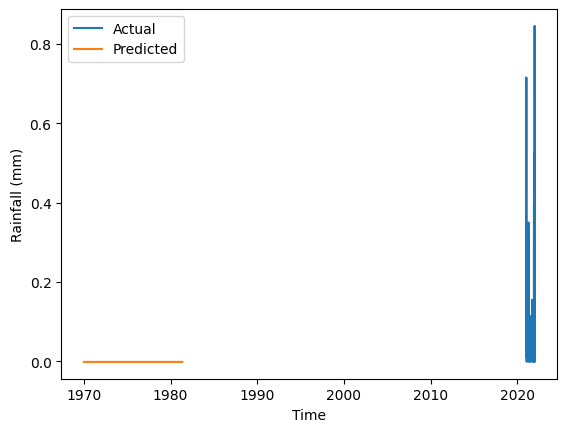

In [29]:
# Plot the actual and predicted values
fig, ax = plt.subplots()
ax.plot(y_test, label='Actual')
ax.plot(y_pred, label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Rainfall (mm)')
ax.legend()
plt.show()